# Clean and Explore the Data

The data scraped from RateMyTeacher.com contains more than just reviews. We have factual information about schools and teachers along with review scores. The resulting review corpus is massive so the language modeling analysis will likely benefit from exploring different parts of the corpus separately to see how contexts and topics change.  

In [11]:
import os 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

from student_voices import sv_utils as bn

## Split Data By Ratings

Now we want to compartmentalize the data into distinct ranges of ratings. Our goal is to acheive a fairly uniform group size for each range. You will notice that the highest rated comments outweight everything else significantly, a first brief insight into the distribution of teacher quality.

In [5]:
data = bn.decompress_pickle('C:/Projects/VirtualMachines/Student_Voices/svvm/Student_Voices/student_voices/data/review_stats.pbz2')

In [3]:
# normalize the ratings to fall in [0,100]
data['Rating'] = (data['Rating']/data['Rating'].max()) * 100

# we bin the data by ratings such that we end up with a similar number of rows in each rating bin 
rating_bins = [0, 35, 60, 65, 75, 85, 95, 101]

# split the ratings data into the bins above and place it in the Range field 
data['Range'] = pd.cut(data['Rating'], rating_bins, right = False)
range_dist = data['Range'].value_counts()

# find the indices for each rating bin
range_indices = {} 
for v in range_dist.keys():
    range_indices[str(v)] = list(data.loc[data['Range']==v].index)
    
# and save the dictionary with the indices
bn.full_pickle(os.getcwd() + '/data/by_rating_range', range_indices)

range_dist.sort_index()

[0, 35)       359387
[35, 60)      309850
[60, 65)      244504
[65, 75)      248963
[75, 85)      404741
[85, 95)      593581
[95, 101)    2702952
Name: Range, dtype: int64

## Creating Labels for Supervised Learning 

In this last part of the notebook we will create labels for the data based on other lakert scale information that the reviewers submitted and explore some more summary statistics. We begin by doing some basic analysis. 

### Exploring the Data

As we can see from the above binned distribution , the sample is heavily skewed towards positive reviews. If we take subsamples of the data such that we only keep teachers who received at least 'n' reviews, we see that this distribution holds. 

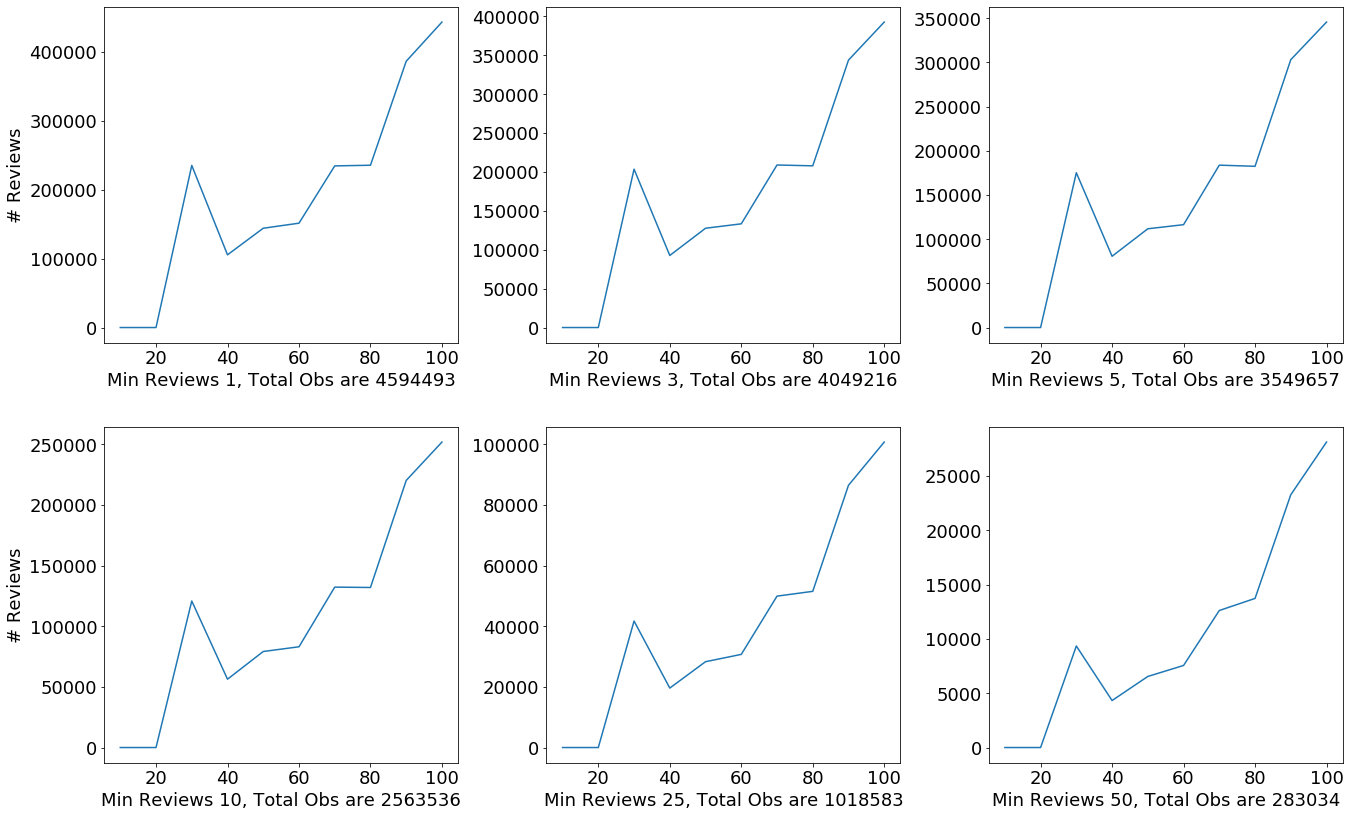

In [13]:
plt.rcParams['axes.facecolor']= 'white'
plt.rcParams['figure.facecolor']= 'white'
plt.rcParams['font.size'] = 18
# create a column containing the number of reviews a given teacher recieved
data['num_reviews'] = data.groupby('Teacher')['FID'].transform('count')

# we will also bin these differently for the histograms
bins = list(range(0,101,10))

# list of the minimum number of reviews 
min_num_reviews = [1,3,5,10,25,50]

plot_num = 8
fig, axes = plt.subplots(2,3)
plt.subplots_adjust(wspace=0.25, hspace=0.25, left=0.1, bottom=0.22, right=0.96, top=0.92)
axes = axes.flatten()
fig.set_size_inches(20, 15)
#fig.suptitle('Distribution of Features')


for i,n in enumerate(min_num_reviews):        
    lbl = 'Min Reviews %d, Total Obs are %d' % (n, (len(data.loc[data['num_reviews']>n])))
    graph_data = pd.cut(data.loc[data['num_reviews']>n, 'Rating'], bins, labels=[int(i) for i in bins[1:]]).dropna()
    vc = pd.DataFrame(graph_data.value_counts().reset_index())
    vc.columns = [lbl, '']
    sns.lineplot(vc[lbl], vc[''], ax=axes[i])
    if i == 0 or i == 3: 
         axes[i].set_ylabel('# Reviews')
#    sns.distplot(pd.cut(data.loc[data['num_reviews']>n, 'Rating'], bins, labels=[int(i) for i in bins[1:]]).dropna(), axlabel=lbl, ax=axes[i])
#    sns.distplot(data.loc[data['num_reviews']>n,'Rating'], bins = bins, axlabel=lbl, ax=axes[i])
#    axes[i].axvline(data.loc[data['num_reviews']>n,'Rating'].mean(),linewidth=1)
#    axes[i].axvline(data.loc[data['num_reviews']>n,'Rating'].median(),linewidth=1, color='r')

fig.savefig('C:/Projects/VirtualMachines/Student_Voices/svvm/Student_Voices//ratings_dist_by_min_reviews.png')

A number of other sub-sample can be created and explored. For example, after 2015 the website began providing reviewers the option to identify as parents or students so for a minority of reviews we can observe this distinction. 

In [14]:
data['SubmittedBy'].value_counts()

Submitted by a student    497506
Submitted by a Parent      22297
Name: SubmittedBy, dtype: int64

School descriptions pulled from RMT also contain useful information about the schools so we extract that into separate variables that we can review. These show that most reviews come from reviewers addressing middle or highschool teachers. This is in line with the low proportion of parents who submit reviews since, in elementary school it would likely be the parents who would submit reviews. 

In [14]:
des = pd.read_csv(os.getcwd() + '/data/school_database.csv')

# remove unnecesary columns 
des = des[[c for c in des.columns if 'Unnamed' not in c]]

# identify school types 
des['public'] = des['school_description'].apply(lambda d: 1 if len(re.findall('[Pp]ublic[\s]*[Ss]chool[^s]', d.split(',')[0])) else 0)
des['middle'] = des['school_description'].apply(lambda d: 1 if len(re.findall('[Mm]iddle[\s]*[Ss]chool[^s]', d.split(',')[0])) else 0)
des['junior'] = des['school_description'].apply(lambda d: 1 if len(re.findall('[Jj]unior', d.split(',')[0])) else 0)
des['elementary'] = des['school_description'].apply(lambda d: 1 if len(re.findall('[Ee]lementary[\s]*[Ss]chool[^s]', d.split(',')[0])) else 0)
des['high'] = des['school_description'].apply(lambda d: 1 if len(re.findall('(?<!unior) [Hh]igh[\s]*[Ss]chool[^s]', d.split(',')[0])) else 0)

# gender distribution 
des['male'] = des['gender'].apply(lambda s: int(re.findall(r'([0-9]*) Male', str(s))[0]) if len(re.findall(r'([0-9]*) Male', str(s)))>0 else np.NaN)
des['female'] = des['gender'].apply(lambda s: int(re.findall(r'([0-9]*) Female', str(s))[0]) if len(re.findall(r'([0-9]*) Male', str(s)))>0 else np.NaN)

# students enrolled 
des['student'] = des['student'].apply(lambda s: re.findall(r'[0-9]*', str(s).replace(',',''))[0] if len(re.findall(r'[0-9]*',str(s)))>0 else np.NaN)
des['student'] = pd.to_numeric(des['student'], errors='coerce')

lvl_dist = pd.merge(data[['Rating','School']],
                    des[['School','middle','junior','elementary','high']],
                    on = 'School', 
                    how = 'outer',
                    indicator = True) 

dist = lvl_dist.groupby('_merge', as_index = False)[['middle','junior','elementary','high']].sum()
dist = dist[dist['_merge'] == 'both'].drop('_merge', 1)
dist.plot.bar()

FileNotFoundError: [Errno 2] File b'C:\\Projects\\VirtualMachines\\Student_Voices\\svvm\\Student_Voices\\notebooks/data/school_database.csv' does not exist: b'C:\\Projects\\VirtualMachines\\Student_Voices\\svvm\\Student_Voices\\notebooks/data/school_database.csv'

### Creating Categorical Labels 

Above we saw that there is some consistency in the data. Now we will process the likert scale data submitted by reviewers. The characteristics rated are listed below. In this first block we check how the data is present by year. As can be seen in the table, only `Clarity`, `Easiness`, and `Helpfulness` are present in every year of the data. ` Knowledge` is available from 2011, `Exam Difficulty` and `Textbook Use` are present from 2013, and the rest are available starting 2015. 

In [4]:
# Create dummy variables for year to illustrate data availability over time 
data=pd.concat([data,
                pd.get_dummies(data['DateTime'].apply(lambda x: x.split('-')[0]),
                               prefix='Year')],
                axis = 1)

characteristics = ['Clarity',
                   'Easiness',
                   'Exam Difficulty',
                   'Helpfulness',
                   'Knowledge',
                   'Textbook Use',
                   'Determination',
                   'Effective',
                   'Empathy',
                   'Homework',
                   'Integrity',
                   'Parent Relation',
                   'Respect']

# Show the availability of variables across years 
yvars = [c for c in data.columns if 'Year_' in c]
corrs = data[characteristics + yvars].corr()
corrs.loc[characteristics, yvars]

,Year_2001,Year_2002,Year_2003,Year_2004,Year_2005,Year_2006,Year_2007,Year_2008,Year_2009,Year_2010,Year_2011,Year_2012,Year_2013,Year_2014,Year_2015,Year_2016,Year_2017,Year_2018
Clarity,0.000570,0.001081,0.006380,-0.008314,-0.004983,-0.009464,-0.008197,-0.010093,0.001412,0.042182,0.024021,0.004160,-0.003427,0.001471,-0.021644,-0.013570,-0.016410,-0.004701
Easiness,-0.013505,-0.002995,-0.001028,-0.014096,-0.015691,-0.015314,-0.015008,-0.013478,0.037282,0.089203,0.059231,0.018003,-0.047144,-0.027661,-0.036052,-0.034201,-0.029181,-0.006070
Exam Difficulty,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.014538,0.010668,-0.003946,-0.000192,0.000283,0.001059
Helpfulness,-0.001413,-0.000520,-0.001404,-0.015866,-0.009995,-0.012547,-0.011848,-0.014412,0.000223,0.040229,0.024456,0.006163,-0.000899,0.008865,-0.009473,0.003403,-0.000938,-0.002172
Knowledge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.013741,0.010850,-0.004940,0.017438,-0.019090,-0.003747,-0.010738,-0.004327
Textbook Use,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.031407,0.059669,0.003305,-0.022251,-0.036976,-0.007009
Determination,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.005601,0.042898,-0.037060,-0.012263
Effective,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.007283,0.052644,-0.046404,-0.009618
Empathy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.005946,0.049902,-0.044145,-0.010798
Homework,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002655,0.026984,-0.026095,-0.010184


Given the above distributions it may be intuitive that some variables are less frequent and more imbalanced than others. In the last block we remap some of the variable values to provide labels sufficient observations for training later. 

In [5]:
# we remap the middle values for exam difficulty and knowledge 
chart = {} 
chart['Exam Difficulty'] = {}
chart['Exam Difficulty'][2] = 1
data['Exam Difficulty']

chart['Knowledge'] = {}
chart['Knowledge'][2] = 1
chart['Knowledge'][4] = 3

# we remap all non-5 values for the remaining, low frequency characteristics 
fullmaps = ['Determination','Effective','Empathy','Homework','Integrity','Parent Relation','Respect']
for c in fullmaps: 
    chart[c] = {}
    chart[c][1] = 1
    chart[c][2] = 1
    chart[c][3] = 1
    chart[c][4] = 1
    data[c] = data[c].replace(chart[c])
    
# create an index for each of the attributes and store it in a dictionary
label_dict = {} 
for c in characteristics: 
    label_dict[c] = {}
    vals = list(data[data[c].notnull()][c].unique())
    val = vals[0]
    for val in vals:
        label_dict[c][val] = list(data.loc[data[c]==val].index)

# we save these indices so we can label the data clearly later on
bn.compressed_pickle(os.getcwd()+'/data/labeled_indices',label_dict)    

for c in characteristics:    
    print(data[c].value_counts())
    print('\n')

5.0    2973130
4.0     780688
3.0     465739
1.0     348314
2.0     272943
Name: Clarity, dtype: int64


5.0    1905620
3.0    1164881
4.0     945497
2.0     519437
1.0     306242
Name: Easiness, dtype: int64


3.0    213756
5.0    158176
4.0    147272
1.0    108101
2.0     87353
Name: Exam Difficulty, dtype: int64


5.0    3134813
4.0     654338
3.0     414405
1.0     369222
2.0     268457
Name: Helpfulness, dtype: int64


5.0    790413
4.0    122363
3.0     61162
1.0     58304
2.0     33487
Name: Knowledge, dtype: int64


1.0    209921
5.0    193305
3.0    129412
4.0     94555
2.0     85916
Name: Textbook Use, dtype: int64


5.0    13612
1.0     8685
Name: Determination, dtype: int64


5.0    14048
1.0     8249
Name: Effective, dtype: int64


5.0    13728
1.0     8569
Name: Empathy, dtype: int64


5.0    11901
1.0    10396
Name: Homework, dtype: int64


5.0    14037
1.0     8260
Name: Integrity, dtype: int64


5.0    14043
1.0     8254
Name: Parent Relation, dtype: int64


5.0    139